In [17]:
import os
import pickle

import lpips
import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import cv2

from scripts import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# input
model_checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler/lightning_logs/version_0/checkpoints/epoch=899.ckpt"
gan_space_path = "experiments/ganspace/dcgan_disc_double_params_padding_reflect_lr_scheduler_epoch=899"
save_path = "experiments/gan_inversion/dcgan_disc_double_params_padding_reflect_lr_scheduler_epoch=899"
layer = "linear"

# important params
os.makedirs(save_path, exist_ok=True)

# optional
n_time= 5
bs = 64
n_iter = 1000
r, c = 32, 64

In [4]:
# load model
model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()
model.cuda()
1

1

In [8]:
pca_path = os.path.join(gan_space_path, layer, "pca.pkl")

f = open(pca_path, 'rb')
pca = pickle.load(f)
f.close()

# load dataset
X = np.concatenate([np.load(os.path.join(gan_space_path, layer, f"X{i+1}.npy")) for i in range(n_time)], axis=0)
y = np.concatenate([np.load(os.path.join(gan_space_path, layer, f"y{i+1}.npy")) for i in range(n_time)], axis=0)

# information gain
information_gain = np.cumsum(pca.explained_variance_ratio_)
idx = np.where(information_gain >= 0.9)[0][0]

# 
comp = pca.components_[:idx]
mean = pca.mean_

# reconstruction
X_pca = (X - mean).dot(comp.T) 

# important
stds= []
for x in X_pca[:, :idx].T:
    stds.append(x.std())
    
E = th.tensor(comp, device=model.device, dtype=th.float32)
mu = th.tensor(mean, device=model.device, dtype=th.float32)

In [12]:
generator = PCAGenerator(model.generator, E, mu)

In [14]:
# fake data loader

# path names
X_fake_path = os.path.join(save_path, "X_fake.npy")
y_fake_path = os.path.join(save_path, "y_fake.npy")

if not os.path.exists(X_fake_path) or not os.path.exists(y_fake_path):
    y_fake = []
    X_fake = []

    with th.no_grad():
        for i in range(10):
            z = []
            for _ in range(n_iter):
                point = [np.random.normal(0, scale) for scale in stds]
                if np.random.uniform(0, 1) < 0.5:
                    point[0] = max(point[0], 11.8467328) if point[0] > 0 else min(point[0], -11.8467328)
                z.append(point)
            z = th.tensor(z, device=model.device)
            x = generator(z)
            y_fake.append(z.detach().cpu())
            X_fake.append(x.detach().cpu())

    y_fake = th.cat(y_fake, axis=0)
    X_fake = th.cat(X_fake, axis=0)

    # save fake dataset
    np.save(X_fake_path, X_fake.detach().cpu().numpy())
    np.save(y_fake_path, y_fake.detach().cpu().numpy())
else:
    X_fake = th.tensor(np.load(X_fake_path))
    y_fake = th.tensor(np.load(y_fake_path))
dataset = TensorDataset(X_fake.detach().cpu(), y_fake.detach().cpu())
dataloader_fake = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=2)

y_fake.shape, X_fake.shape

(torch.Size([10000, 28]), torch.Size([10000, 3, 32, 64]))

In [120]:
# real data loader

X_real_path = os.path.join(save_path, "X_real.npy")

cars = np.load("../potsdam_data/potsdam_cars/cars.npy", allow_pickle=True)

if not os.path.exists(X_real_path):
    X_real = []
    for car in tqdm.tqdm(cars):
        car = cv2.cvtColor(car, cv2.BGR2RGB)
        car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)

        # scaling -1, 1
        car_resized = 2*(car_resized / 255) - 1

        # append
        X_real.append(np.expand_dims(car_resized, axis=0))

    X_real = np.concatenate(X_real, axis=0)

    # save real dataset
    np.save(X_real_path, X_real)
else:
    X_real = np.load(X_real_path)

X_real = th.tensor(X_real, dtype=X_fake.dtype)

dataset = TensorDataset(X_real, X_real)
dataloader_real = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=2)

X_real.shape

torch.Size([4302, 3, 32, 64])

In [122]:
# val data loader

X_real_path = os.path.join(save_path, "X_real_val.npy")

cars = np.load("../potsdam_data/potsdam_cars_val/cars.npy", allow_pickle=True)

if not os.path.exists(X_real_path):
    X_real = []
    for car in cars:
        car = cv2.cvtColor(car, cv2.COLOR_RGB2BGR)
        car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)
        
        # scaling -1, 1
        car_resized = 2*(car_resized / 255) - 1

        # append
        X_real.append(np.expand_dims(car_resized, axis=0))
        
    X_real = np.concatenate(X_real, axis=0)

    # save real dataset
    np.save(X_real_path, X_real)
else:
    X_real = np.load(X_real_path)

X_real = th.tensor(X_real, dtype=X_fake.dtype)

dataset = TensorDataset(X_real, X_real)
dataloader_val = DataLoader(dataset, batch_size=2*bs, shuffle=True, num_workers=2)

X_real.shape

torch.Size([414, 3, 32, 64])

In [33]:
net = EncoderLatent(generator).cuda()
optimizer = th.optim.Adam(net.parameters(), lr=0.001)
loss_latent = th.nn.L1Loss(reduction="mean")
loss_rec1 = th.nn.L1Loss(reduction="mean")
loss_rec2 = lpips.LPIPS(net='vgg').cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/hca/Documents/Master/Thesis/Master-Thesis/.env/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [34]:
from torchsummary import summary
summary(net.cuda(), (3, 32, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 64]           1,728
       BatchNorm2d-2           [-1, 64, 32, 64]             128
         LeakyReLU-3           [-1, 64, 32, 64]               0
         ConvBlock-4           [-1, 64, 32, 64]               0
         MaxPool2d-5           [-1, 64, 16, 32]               0
            Conv2d-6          [-1, 128, 16, 32]          73,728
       BatchNorm2d-7          [-1, 128, 16, 32]             256
         LeakyReLU-8          [-1, 128, 16, 32]               0
         ConvBlock-9          [-1, 128, 16, 32]               0
        MaxPool2d-10           [-1, 128, 8, 16]               0
           Conv2d-11           [-1, 256, 8, 16]         294,912
      BatchNorm2d-12           [-1, 256, 8, 16]             512
        LeakyReLU-13           [-1, 256, 8, 16]               0
        ConvBlock-14           [-1, 256

In [35]:
net.train()

learning_curve = []
learning_curve_val = []
n_iter = 301

for i in range(n_iter):

    x_fake, z_fake = next(iter(dataloader_fake))
    x_real, _ = next(iter(dataloader_real))
    
    optimizer.zero_grad()
    z_fake_, x_fake_ = net.forward(x_fake.cuda())
    _, x_real_ = net.forward(x_real.cuda())


    loss_1 = loss_latent(z_fake_, z_fake.cuda())
    loss_2 = loss_rec1(x_fake_, x_fake.cuda()) + loss_rec1(x_real_, x_real.cuda())
    loss_3 = th.mean(loss_rec2(x_fake_, x_fake.cuda(), normalize=True)) + \
             th.mean(loss_rec2(x_real_, x_real.cuda(), normalize=True))
    total_loss = loss_1 + loss_2 + loss_3
    
    learning_curve.append(total_loss.item())
    
    total_loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print("iteration ", i, "loss", learning_curve[-1])
    
    if i % 90 == 0:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
    
    if i % 100 == 0:
        with th.no_grad():
            net.eval()
            l = 0
            for x_val, _ in dataloader_val:
                _, x_val_ = net.forward(x_val.cuda())
                l += th.mean(loss_rec2(x_val_, x_val.cuda(), normalize=True)).item()
                l += loss_rec1(x_val_, x_val.cuda()).item()
            print("iteration ", i, "val loss", l)
            learning_curve_val.append(l)
            net.train()
        th.save(net.state_dict(), os.path.join(save_path, f"iter={i}.pkl"))

iteration  0 loss 5.756210803985596
iteration  0 val loss tensor(3.1509, device='cuda:0')
iteration  10 loss 5.106329917907715
iteration  20 loss 4.779513359069824
iteration  30 loss 4.505547523498535
iteration  40 loss 4.3947954177856445
iteration  50 loss 4.268649578094482
iteration  60 loss 4.310161590576172
iteration  70 loss 3.9060816764831543
iteration  80 loss 3.9853904247283936
iteration  90 loss 3.7870380878448486
iteration  100 loss 3.7337608337402344
iteration  100 val loss tensor(1.7703, device='cuda:0')
iteration  110 loss 3.5925612449645996
iteration  120 loss 3.770880699157715
iteration  130 loss 3.648646593093872
iteration  140 loss 3.576219081878662
iteration  150 loss 3.625713586807251
iteration  160 loss 3.637026309967041
iteration  170 loss 3.7095563411712646
iteration  180 loss 3.7327170372009277
iteration  190 loss 3.7287635803222656
iteration  200 loss 3.689666509628296
iteration  200 val loss tensor(1.7314, device='cuda:0')
iteration  210 loss 3.7044663429260254

Text(0, 0.5, 'MSE')

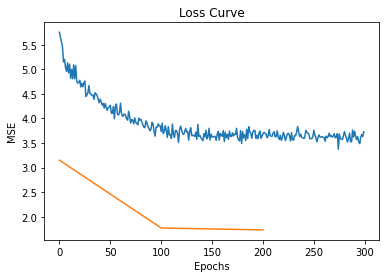

In [37]:
plt.plot(learning_curve)
plt.plot([100*i for i in range(len(learning_curve_val))], learning_curve_val)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [38]:
best_model_iter = 300
net.load_state_dict(th.load(os.path.join(save_path, f"iter={best_model_iter}.pkl")))
net.cuda()
net.eval()

EncoderLatent(
  (generator): PCAGenerator(
    (generator): BasicGenerator(
      (l1): Linear(in_features=100, out_features=4096, bias=True)
      (conv_blocks): Sequential(
        (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Upsample(scale_factor=2.0, mode=nearest)
        (2): ConvBlock(
          (conv_block): ModuleList(
            (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
            (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): LeakyReLU(negative_slope=0.2, inplace=True)
          )
        )
        (3): Upsample(scale_factor=2.0, mode=nearest)
        (4): ConvBlock(
          (conv_block): ModuleList(
            (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

([], [])

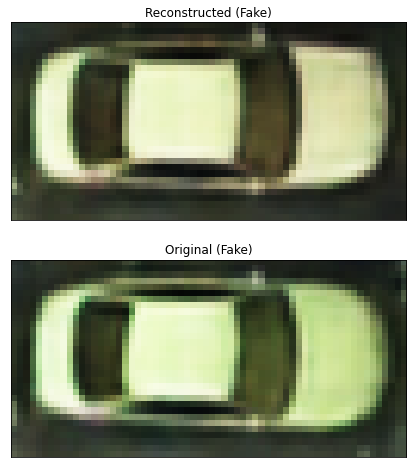

In [183]:
# testing
with th.no_grad():
    z = [np.random.normal(0, scale) for scale in stds]
    z[0] = max(point[0], 11.8467328) if point[0] > 0 else min(point[0], -11.8467328)
    z = th.tensor(z, device=model.device)

    x_orig = generator(z)

    z_rec, _ = net.forward(x_orig)
    x_rec = generator(z_rec)

# rescale
x_rec = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec)
plt.title("Reconstructed (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig)
plt.title("Original (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])

([], [])

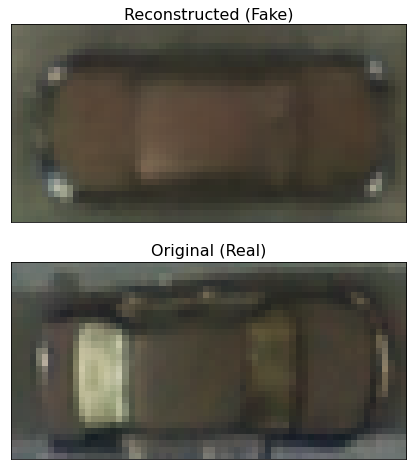

In [180]:
i = 50
x_val, _ = next(iter(dataloader_val))

x_orig = th.unsqueeze(x_val[i], axis=0)
z_rec, _ =  net.forward(x_orig.cuda())
x_rec = generator(z_rec)

# rescale
x_rec = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec)
plt.title("Reconstructed (Fake)", fontsize=16)
plt.xticks([])

plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig)
plt.title("Original (Real)", fontsize=16)
plt.xticks([])
plt.yticks([])